<a href="https://colab.research.google.com/github/Mahrokh-Eb/Deep-Learning-with-Python/blob/main/catVSdog_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cat VS dog Classification_V3

In [16]:
# using kaggle dataset, trying to spilit cat and dog classes into train, validation
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
%cd /content/drive/MyDrive/dogVsCat

/content/drive/MyDrive/dogVsCat


In [18]:
#!pip3 install bcolz  

In [19]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

In [20]:
DATA_DIR ='/content/drive/MyDrive/dogVsCat/kaggle/'

sz = 224
batch_size = 16

In [21]:
os.listdir(DATA_DIR)

['sampleSubmission.csv', 'DR', 'test1', 'train']

In [22]:
trn_dir = f'{DATA_DIR}train'
test_dir = f'{DATA_DIR}test1'

In [23]:
os.listdir(trn_dir)

['cat', 'dog']

In [13]:
trn_fnames = glob.glob(f'{trn_dir}/*/*')
trn_fnames[:5]

['/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11500.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11501.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11502.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11503.jpg',
 '/content/drive/MyDrive/dogVsCat/kaggle/train/cat/11504.jpg']

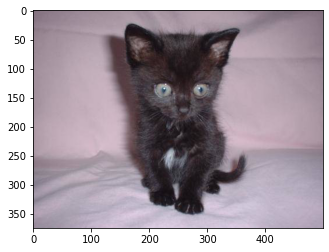

In [14]:
img = plt.imread(trn_fnames[14])
plt.imshow(img);

#Dataset 

In [15]:
tfms = transforms.Compose([
                           transforms.Resize((sz, sz)),
                           transforms.ToTensor(),
                           transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.244, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms) 

In [24]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [25]:
len(train_ds)

37499

#Dataloader

In [26]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


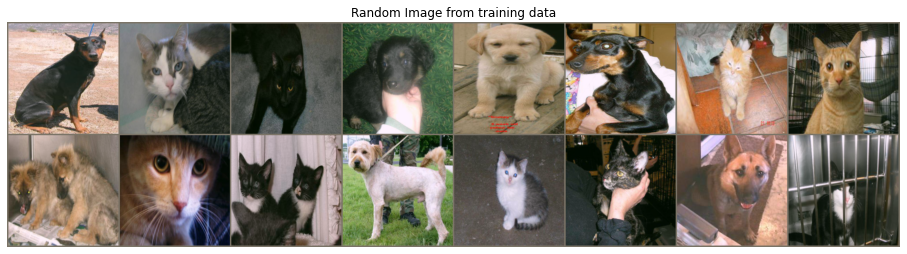

In [27]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16,12))
imshow(out, title='Random Image from training data')

#Model: CNN

In [29]:
# ??imshow, khode razavi nevesht